In [1]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.optimize as opt
from tqdm.notebook import tqdm
import seaborn as sns
sns.set()

In [2]:
import grsam

# Initialization

**Instanciation**

In [3]:
portf = grsam.Portfolio(horizon=50)

**Parameters' initialization**

In [4]:
def standard_initialization(portfolio):
    """
    Initialize the class with standard values to perform tests
    """
    ### utility ###
    portfolio.init_utility()
    
    ### GH nodes ###
    portf.init_GaussHermite(n_Gauss=11)

    ### Constraints ###
    portf.init_constraints()

standard_initialization(portf)

**Note on the constraints**  
Required when solving for optimal portfolios  

`scipy.optimize.LinearConstraint` has the general inequality form: $lb \le Ax \le ub$.  
Here
$$\begin{pmatrix}-\infty\\0\\0\end{pmatrix} \le \begin{pmatrix}\theta_1+\theta_2\\\theta_1\\\theta_2\end{pmatrix} \le \begin{pmatrix}1\\\infty\\\infty\end{pmatrix}$$

In [5]:
def init_asset_dist(portfolio, m, vol1, vol2, rho):
    """
    Initialize the assets' distribution
    """
    cov = rho * vol1 * vol2
    sigma = np.array([[vol1**2, cov],
                      [cov, vol2**2]])
    portfolio.init_assets(risk_free_rate=0.02, mean=m, covariance=sigma)
    
    ### print values ###
    print("Bivariate distribution")
    print(f" mean vector: {portfolio.mean}")
    print(f" covariance matrix: {portfolio.cov[0,:]}")
    print(f"                    {portfolio.cov[1,:]}")

def init_prior_dist(portfolio, m_belief, factor1, factor2, corr):
    """
    Initialize the assets' means' prior distribution
    """
    var1 = portf.cov[0,0]
    var2 = portf.cov[1,1]
    cov = corr * np.sqrt(factor1*var1*factor2*var2)
    sigma_belief = np.array([[factor1*var1, cov],
                              [cov, factor2*var2]])
    
    portfolio.init_belief(mean_belief=m_belief, covariance_belief=sigma_belief)

    ### print values ###
    print("Prior over the mean vector")
    print(f" mean vector: {portfolio.mean_belief_init}")
    print(f" covariance matrix: {portfolio.cov_belief_init[0,:]}")
    print(f"                    {portfolio.cov_belief_init[1,:]}")

init_asset_dist(portf,
                m = np.array([0.05, 0.05]),
                vol1 = 0.2,
                vol2 = 0.2,
                rho=0
                )
init_prior_dist(portf,
                m_belief = np.array([0.05, 0.05]),
                factor1 = 1/10,
                factor2 = 1/4,
                corr=0)


Bivariate distribution
 mean vector: [0.05 0.05]
 covariance matrix: [0.04 0.  ]
                    [0.   0.04]
Prior over the mean vector
 mean vector: [0.05 0.05]
 covariance matrix: [0.004 0.   ]
                    [0.   0.01]


# Comparison of simple and double quadrature with CRRA EU

maximum absolute difference: 8.881784197001252e-16
optimal portfolio simple quadrature: [0.51631125 0.48368875]
optimal portfolio double quadrature: [0.51631119 0.48368881]


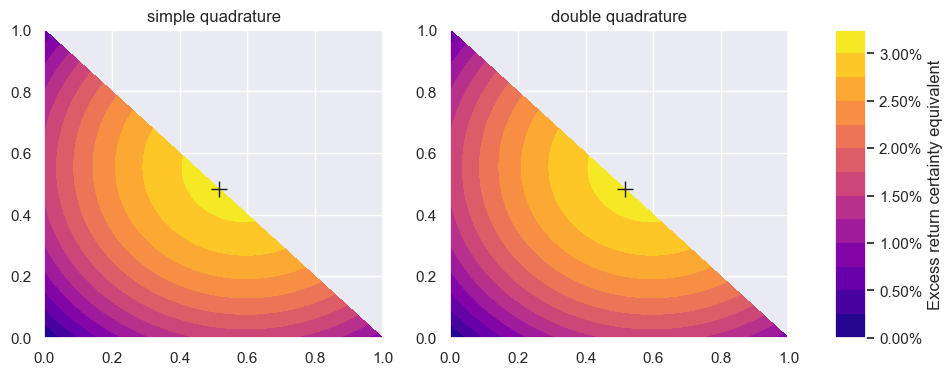

In [6]:
def compare_quadrature_CRRA_EU(portfolio, n_grid_points=101):
    """
    Compute and plot CRRA EU for a grid of portfolios on the simplex
    using single and double quadrature for comparison
    """    
    # initialize single quadrature with predictive distribution
    portfolio.init_corr_nodes(cov=portfolio.cov+portfolio.cov_belief_init)
    (X, Y, Z), theta_star = portfolio.grid_CRRA_EU(n_grid_points, d_quad=False)
    
    # initialize double quadrature
    portfolio.init_corr_nodes(cov=portf.cov)
    portfolio.init_corr_nodes_double(cov_outer=portfolio.cov_belief_init)
    (X, Y, Z_d), theta_star_d = portfolio.grid_CRRA_EU(n_grid_points, d_quad=True)
    
    print(f"maximum absolute difference: {np.nan_to_num(np.abs(Z-Z_d)).max()}")
    print(f"optimal portfolio simple quadrature: {theta_star}")
    print(f"optimal portfolio double quadrature: {theta_star_d}")
    
    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    axs[0].contourf(X, Y, Z, cmap='plasma', levels=12)
    axs[0].plot(theta_star[0], theta_star[1], 'k+', markersize=12)
    s = axs[1].contourf(X, Y, Z_d, cmap='plasma', levels=12)
    axs[1].plot(theta_star_d[0], theta_star_d[1], 'k+', markersize=12) 
    axs[0].set_title("simple quadrature")
    axs[1].set_title("double quadrature")
    fig.colorbar(s, aspect=10, ax=axs.ravel().tolist(),
                 format=mtick.PercentFormatter(1),
                 label="Excess return certainty equivalent")

compare_quadrature_CRRA_EU(portf)

# CRRA EU Portfolios on the Simplex

In [7]:
def plot_EU_portfolios(portfolio, means_1, means_2):
    """
    plot CRRA EU certainty equivalents of portfolios on the simplex
    for different values in mean 1 and mean 2
    """
    portfolio.init_corr_nodes(cov=portf.cov)
    portfolio.init_corr_nodes_double(cov_outer=portfolio.cov_belief_init)

    n_cols = len(means_1)
    n_rows = len(means_2)
    fig, axs = plt.subplots(n_rows, n_cols,
                            figsize=(4.5*n_cols, 4*n_rows),
                            sharex=True,
                            sharey=True)
    M1, M2 = np.meshgrid(means_1, means_2)
    for m1, m2, ax in zip(M1.ravel(), M2.ravel(), axs.ravel()):
        m_belief0 = np.array([m1, m2])
        portfolio.mean_belief_init = m_belief0
        (X, Y, Z), theta_star = portfolio.grid_CRRA_EU(n_grid_points=25, d_quad=True)
        s = ax.contourf(X, Y, Z, cmap='plasma')
        ax.plot(theta_star[0], theta_star[1], 'k+', markersize=12)
        theta_star_string = np.array2string(theta_star, 
                                            precision=3,
                                            suppress_small=True,
                                            separator=", ",
                                            floatmode='fixed'
                                           )
        title = f"$\mu_1$ = {m1:.2f}, $\mu_2$ = {m2:.2f}"
        title += "\n"
        title += r"$\theta^\ast=$"
        title += theta_star_string
        ax.set_title(title)
    
    for ax in axs[-1,:]:
        ax.set_xlabel("asset 1")
    for ax in axs[:,0]:
        ax.set_ylabel("asset 2")
        
    
    fig.suptitle(f"Certainty Equivalents of portfolios for CRRA utility")
    fig.colorbar(s, aspect=10, shrink = 1/n_rows,
                 ax=axs.ravel().tolist(),
                 format=mtick.PercentFormatter(1),
                 label="Excess return certainty equivalent")
    return fig

In [8]:
means = [0.03, 0.05, 0.07]

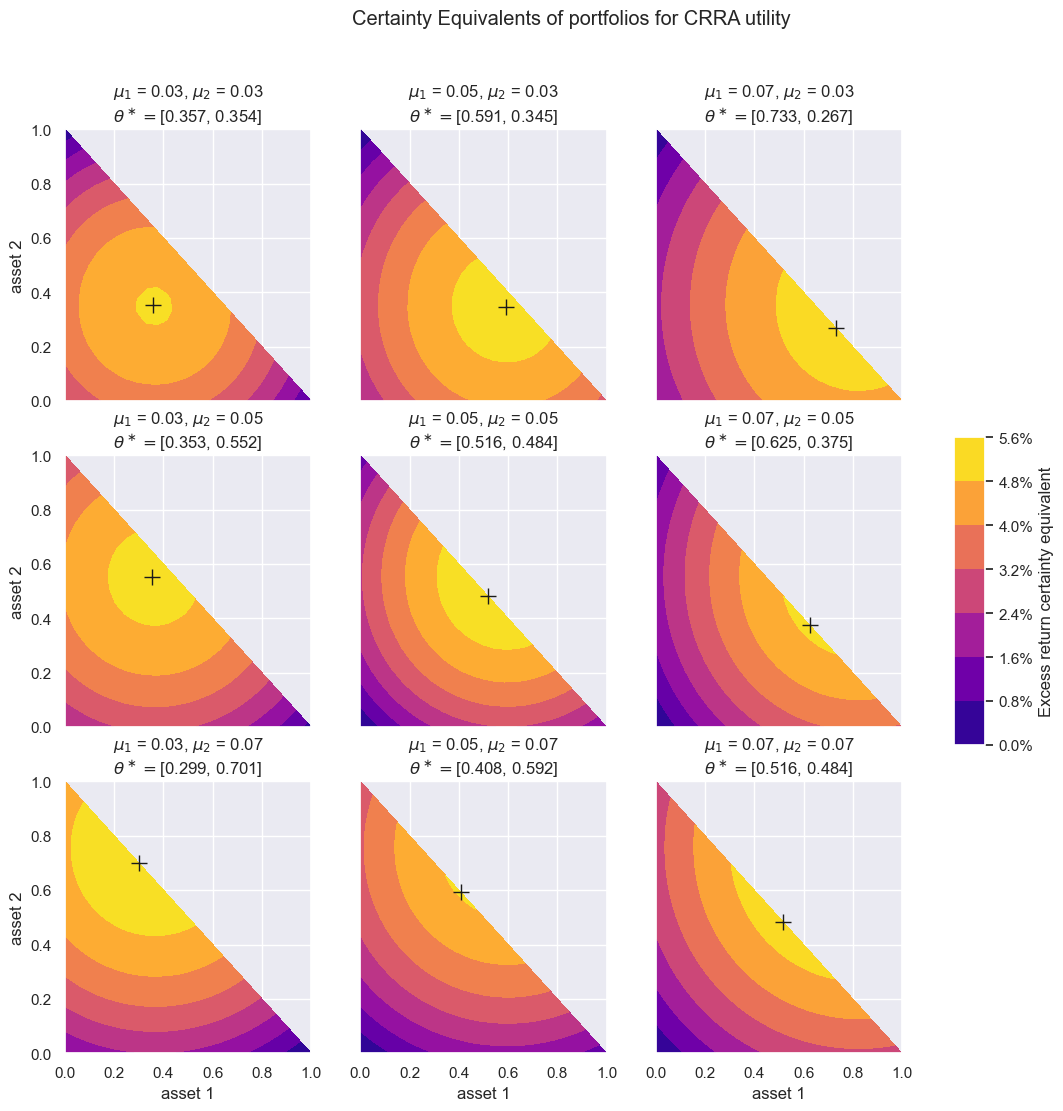

In [9]:
fig_EU = plot_EU_portfolios(portf, means_1=means, means_2=means)

# KMM Portfolios in the simplex

In [10]:
def plot_KMM_portfolios(portfolio, means_1, means_2):
    """
    plot KMM certainty equivalents of portfolios on the simplex
    for different values in mean 1 and mean 2
    """
    portfolio.init_corr_nodes(cov=portf.cov)
    portfolio.init_corr_nodes_double(cov_outer=portfolio.cov_belief_init)

    n_cols = len(means_1)
    n_rows = len(means_2)
    fig, axs = plt.subplots(n_rows, n_cols,
                            figsize=(4.5*n_cols, 4*n_rows),
                            sharex=True,
                            sharey=True)
    M1, M2 = np.meshgrid(means_1, means_2)
    for m1, m2, ax in zip(M1.ravel(), M2.ravel(), axs.ravel()):
        m_belief0 = np.array([m1, m2])
        portfolio.mean_belief_init = m_belief0
        (X, Y, Z), theta_star = portfolio.grid_KMM(n_grid_points=25)
        s = ax.contourf(X, Y, Z, cmap='plasma')
        ax.plot(theta_star[0], theta_star[1], 'k+', markersize=12)
        theta_star_string = np.array2string(theta_star, 
                                            precision=3,
                                            suppress_small=True,
                                            separator=", ",
                                            floatmode='fixed'
                                           )
        title = f"$\mu_1$ = {m1:.2f}, $\mu_2$ = {m2:.2f}"
        title += "\n"
        title += r"$\theta^\ast=$"
        title += theta_star_string
        ax.set_title(title)
    
    for ax in axs[-1,:]:
        ax.set_xlabel("asset 1")
    for ax in axs[:,0]:
        ax.set_ylabel("asset 2")
        
    
    fig.suptitle(f"Certainty Equivalents of portfolios for KMM utility")
    fig.colorbar(s, aspect=10, shrink = 1/n_rows,
                 ax=axs.ravel().tolist(),
                 format=mtick.PercentFormatter(1),
                 label="Excess return certainty equivalent")
    return fig

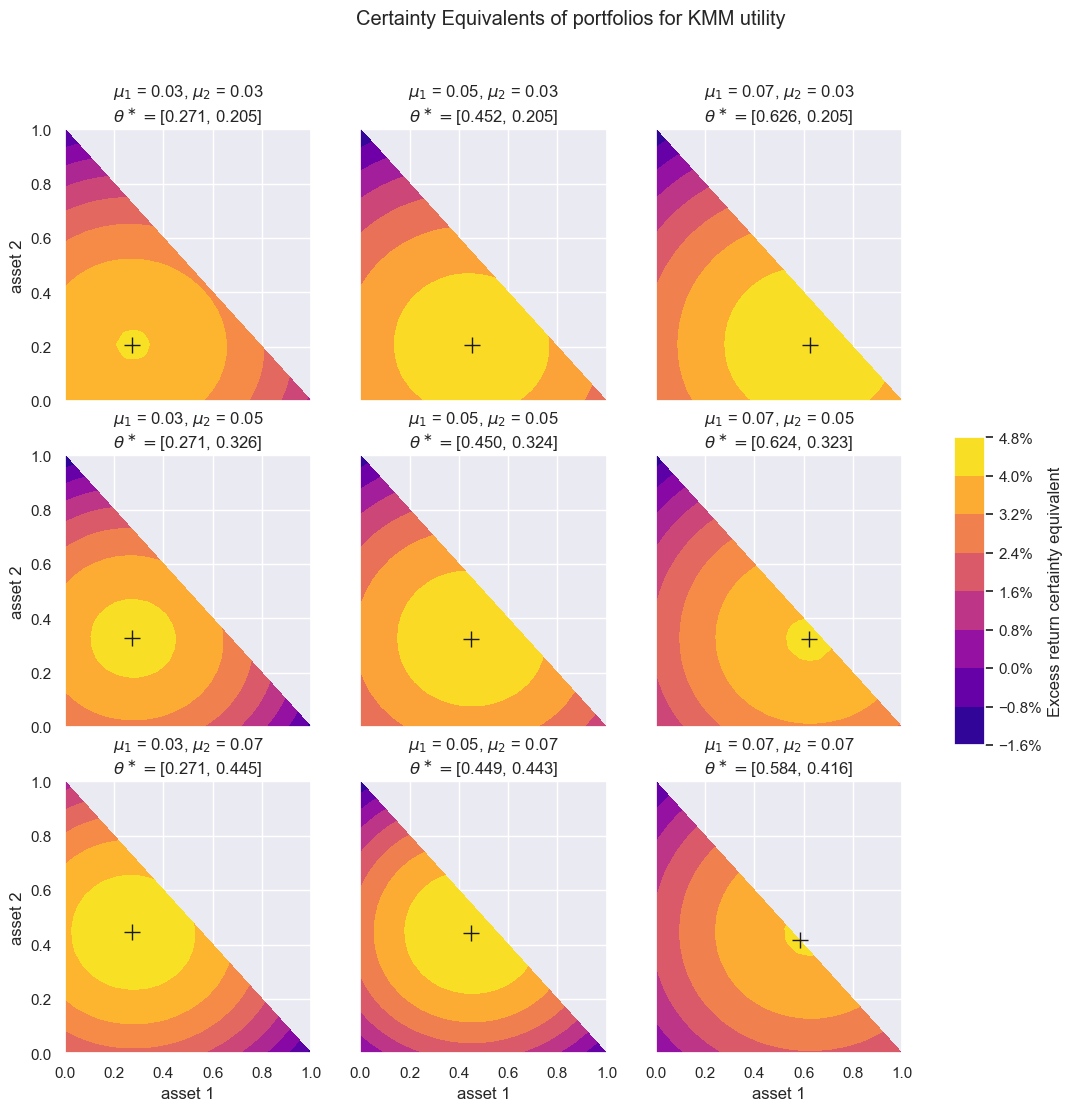

In [11]:
fig_KMM = plot_KMM_portfolios(portf, means_1=means, means_2=means)

## KMM ambiguity neutral  

Setting $\eta = \gamma$ reduces the KMM evaluation to EU.

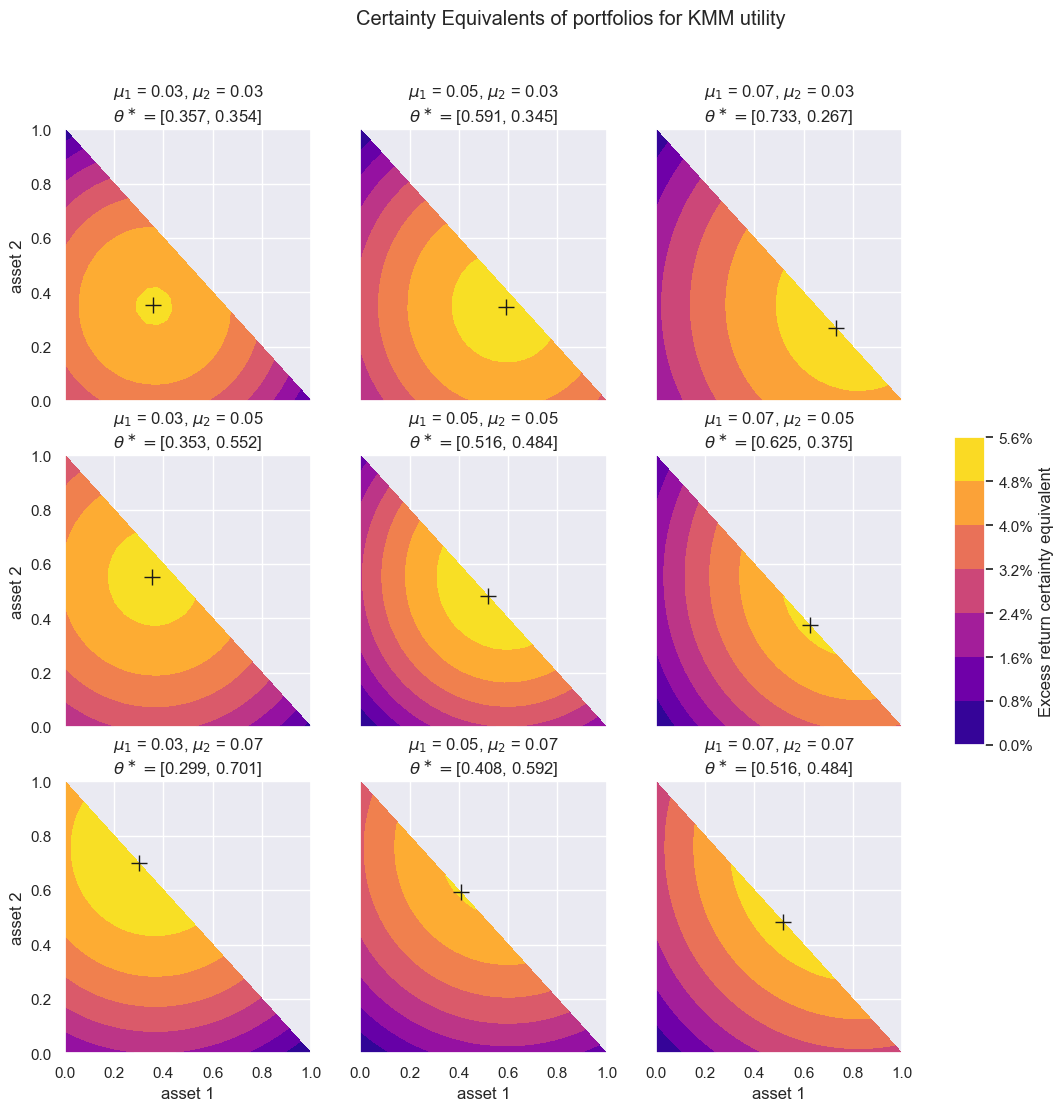

In [12]:
portf.init_utility(eta=2)
fig_KMM_neutral = plot_KMM_portfolios(portf, means_1=means, means_2=means)

# Effect of correlation

In [13]:
init_prior_dist(portf,
                m_belief = np.array([0.05, 0.05]),
                factor1 = 1/10,
                factor2 = 1/4,
                corr=-0.8)

Prior over the mean vector
 mean vector: [0.05 0.05]
 covariance matrix: [ 0.004      -0.00505964]
                    [-0.00505964  0.01      ]


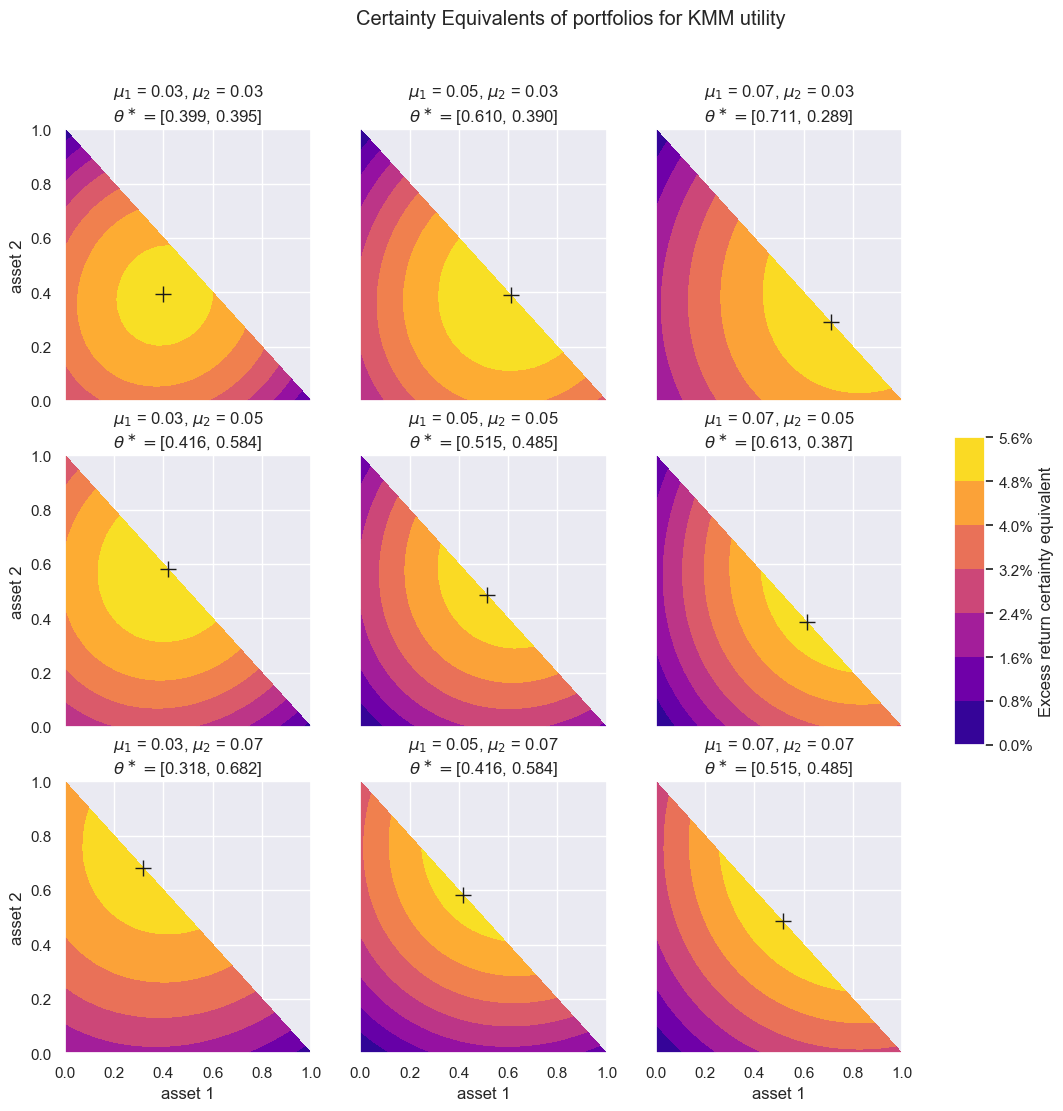

In [14]:
fig = plot_KMM_portfolios(portf, means_1=means, means_2=means)

In [15]:
init_prior_dist(portf,
                m_belief = np.array([0.05, 0.05]),
                factor1 = 1/10,
                factor2 = 1/4,
                corr=0.8)

Prior over the mean vector
 mean vector: [0.05 0.05]
 covariance matrix: [0.004      0.00505964]
                    [0.00505964 0.01      ]


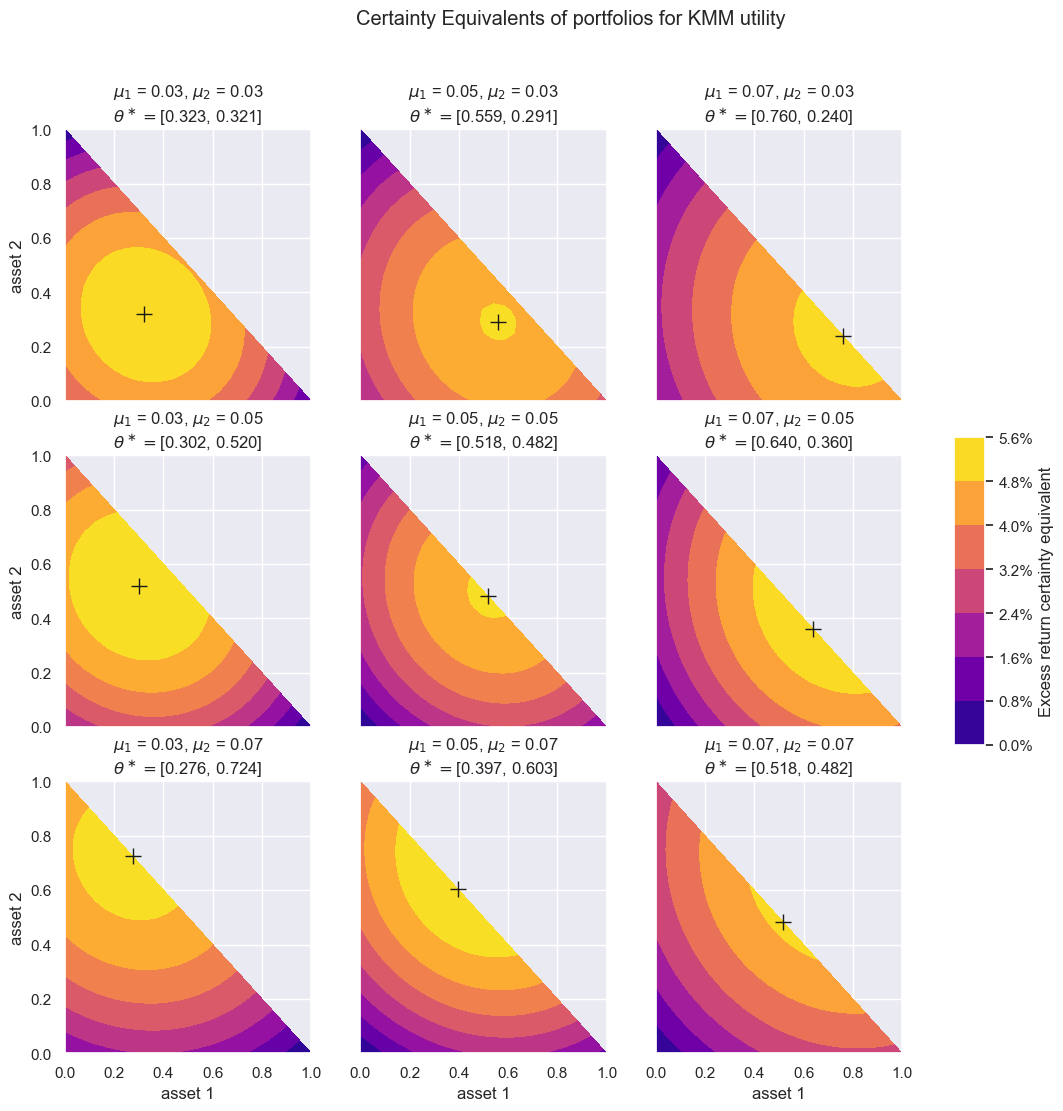

In [16]:
fig = plot_KMM_portfolios(portf, means_1=means, means_2=means)

In [17]:
def correlation_grid(portfolio):

    def KMM_CE(theta):
        """
        Certainty equivalents with KMM of portfolio `theta`
        see the class function `tildeH()`
        returns opposite for use with scipy.optimize.minimize
        """
        ret = portfolio.rf + theta[0] * R1 + theta[1] * R2
        ret **= 1 - portfolio.gamma
        E = portfolio.inner_quadrature(ret)
        E **= (1-portfolio.eta) / (1-portfolio.gamma)
        KMM = portfolio.outer_quadrature(E)
        CEquiv = KMM ** (1/(1-portfolio.eta))
        return -CEquiv

    data = []
    var1 = portf.cov[0,0]
    var2 = portf.cov[1,1]
    factor1 = 1/10
    factor2 = 1/4
    correls = [-0.8, -0.4, 0, 0.4, 0.8]
    means = [0.03, 0.05, 0.07]
    
    M1, M2 = np.meshgrid(means, means)
    for m1, m2 in zip(M1.ravel(), M2.ravel()):
        m_belief = np.array([m1, m2])
        for prior_corr in correls:
            cov = prior_corr * np.sqrt(factor1*var1*factor2*var2)
            sigma_belief = np.array([[factor1*var1, cov],
                                     [cov, factor2*var2]])
            for corr in correls:
                cov = corr * np.sqrt(var1*var2)
                sigma = np.array([[var1, cov],
                                  [cov, var2]])
                portfolio.init_corr_nodes(cov=sigma)
                portfolio.init_corr_nodes_double(cov_outer=sigma_belief)
                R1 = np.exp(m1 + portfolio.R1_d) - portfolio.rf
                R2 = np.exp(m2 + portfolio.R2_d) - portfolio.rf
                res = opt.minimize(KMM_CE, (0.25,0.25), constraints=portfolio.cons)
                data.append([m1, m2, corr, prior_corr, res.x[0], res.x[1]])
    df = pd.DataFrame(data, columns=['m1', 'm2', 'corr', 'prior_corr', 'theta1', 'theta2'])
    return df

In [18]:
df = correlation_grid(portf)
df.head()

,m1,m2,corr,prior_corr,theta1,theta2
0,0.03,0.03,-0.8,-0.8,0.508122,0.491878
1,0.03,0.03,-0.4,-0.8,0.511365,0.488635
2,0.03,0.03,0.0,-0.8,0.398879,0.394788
3,0.03,0.03,0.4,-0.8,0.290265,0.288858
4,0.03,0.03,0.8,-0.8,0.227238,0.227462


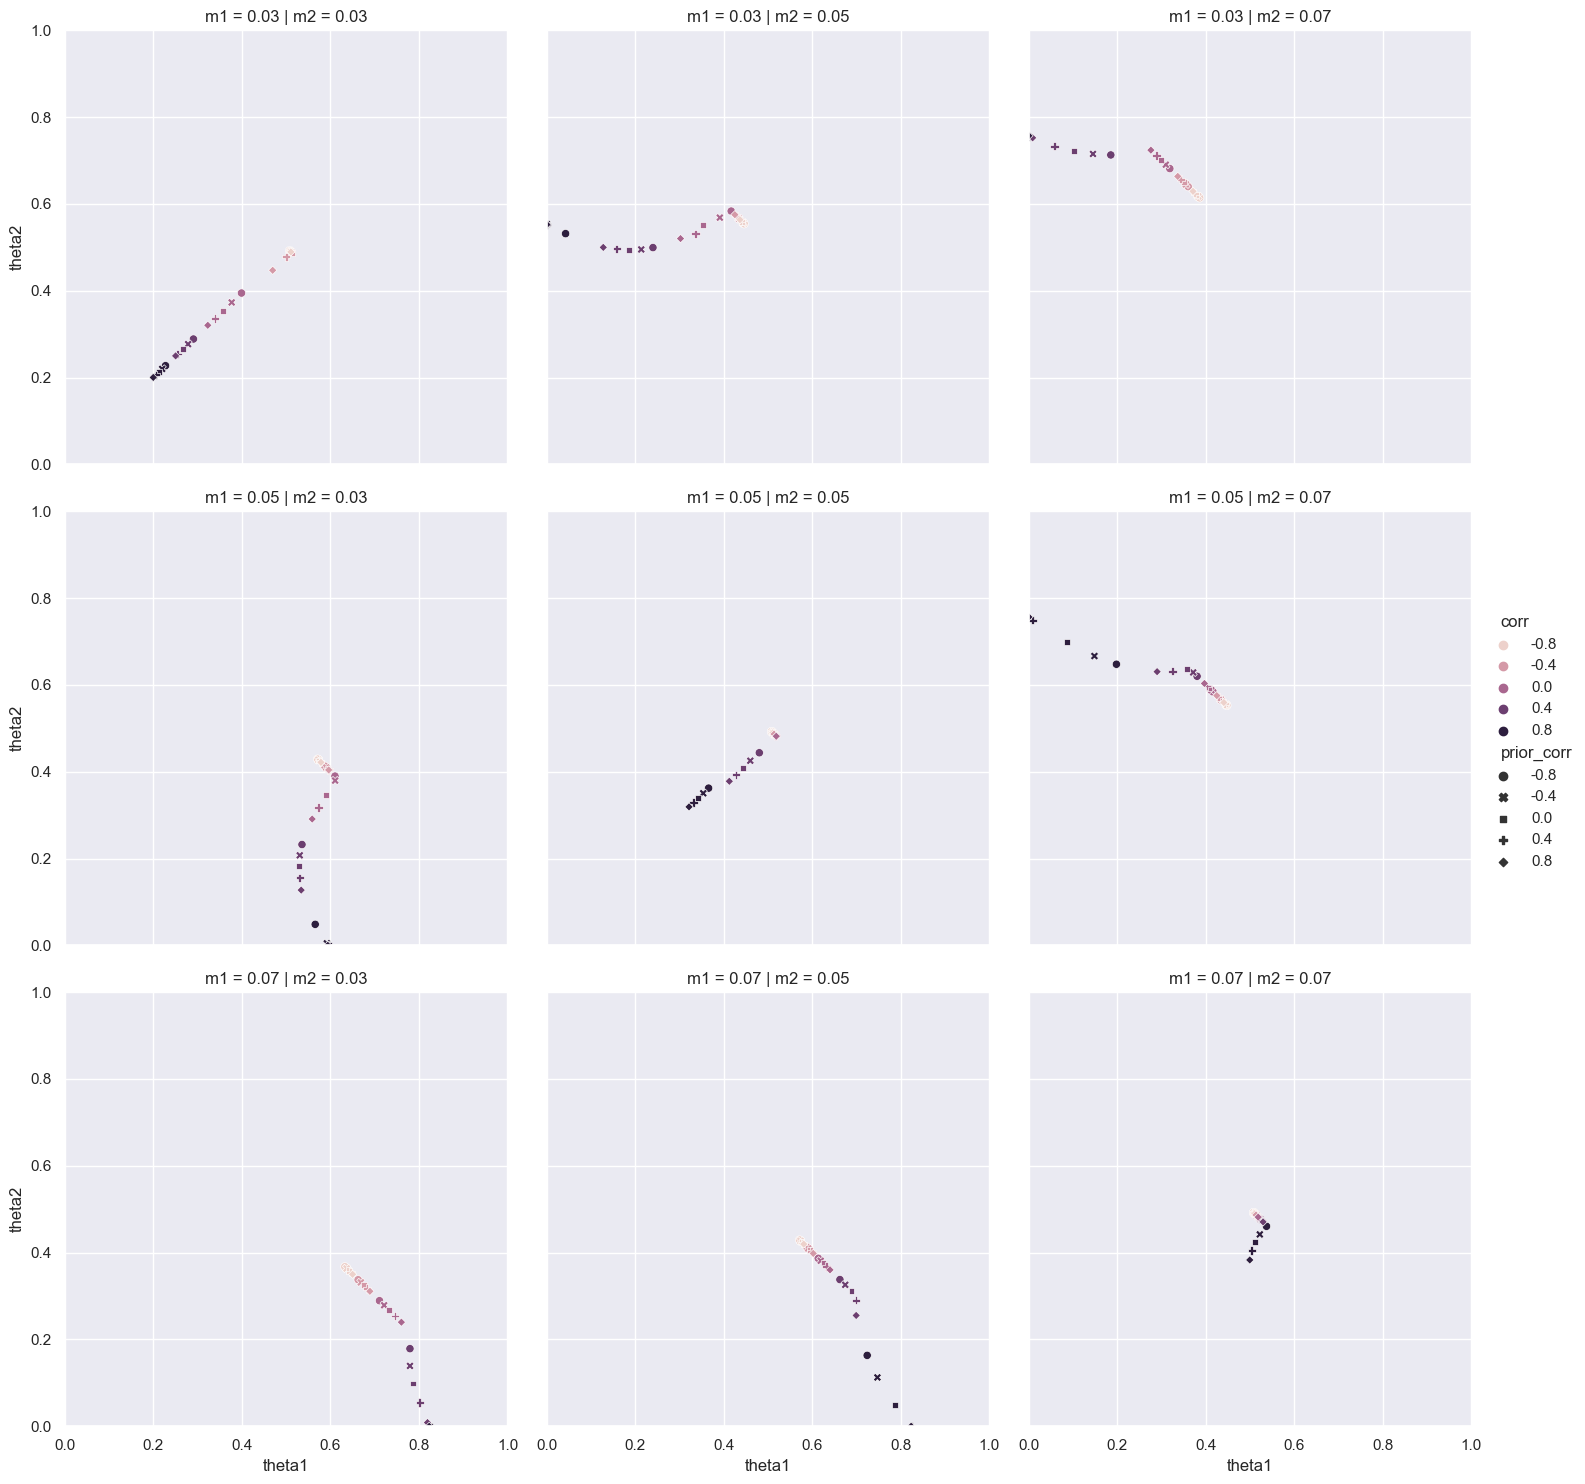

In [19]:
sns.relplot(data=df, x='theta1', y='theta2',
            row='m1', col='m2',
            hue='corr', style='prior_corr',
            facet_kws={'xlim':[0,1], 'ylim':[0,1]});

# Sensitivities of KMM portfolios to the prior

In [20]:
def KMM_portfolios(portfolio, priors):
    
    def KMM_CE(theta):
        """
        Certainty equivalents with KMM of portfolio `theta`
        see the class function `tildeH()`
        returns opposite for use with scipy.optimize.minimize
        """
        ret = rf + theta[0] * R1 + theta[1] * R2
        ret **= γ
        E = portfolio.inner_quadrature(ret)
        E **= η / γ
        KMM = portfolio.outer_quadrature(E)
        CEquiv = KMM ** (1/η)
        return -CEquiv
    
    out = []
    γ, η = 1-2, 1-8.864 #store 1-gamma and 1-eta
    rf = 1 + 0.02
    m = np.array([0.05, 0.05])
    vol1 = 0.2
    vol2 = 0.2
    rho = 0.5
    cov = rho * vol1 * vol2
    sigma = np.array([[vol1**2, cov],
                      [cov, vol2**2]])
    
    portfolio.init_GaussHermite(n_Gauss=11)
    portf.init_constraints()
    
    # iterable for prior means
    prior_mean_iter = list(product(priors['mean1'], priors['mean2']))
    # iterable for prior covariance matrices
    prior_cov_iter = list(product(priors['vol1'],
                                  priors['vol2'],
                                  priors['correl']
                                 )
                         )
    
    for μ1, μ2 in tqdm(prior_mean_iter, desc="prior means"):
        m_belief = np.array([μ1, μ2])
        #for λ1, λ2, pcorr in tqdm(prior_cov_iter, desc="prior covariance", leave=True):
        for λ1, λ2, pcorr in prior_cov_iter:
            sigma_belief = np.array([[λ1**2, pcorr*λ1*λ2],[pcorr*λ1*λ2, λ2**2]])
            portfolio.init_corr_nodes(cov=sigma)
            portfolio.init_corr_nodes_double(cov_outer=sigma_belief)
            R1 = np.exp(μ1 + portfolio.R1_d) - rf
            R2 = np.exp(μ2 + portfolio.R2_d) - rf
            res = opt.minimize(KMM_CE, (0.25,0.25), constraints=portfolio.cons)
            out.append([μ1, μ2, λ1, λ2, pcorr, res.x[0], res.x[1], res.x.sum()])
    
    col_headers = ['mu1', 'mu2', 'lambda1', 'lambda2', 'corr', 'theta1', 'theta2', 'participation']
    df = pd.DataFrame(out, columns=col_headers)
    return df

In [21]:
m = np.array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08])
v = np.array([0.02, 0.05, 0.08, 0.1, 0.15, 0.2])
prior_dict = {'mean1': m,
              'mean2': m,
              'vol1': v,
              'vol2': v,
              'correl': np.array([-0.8, -0.5, -0.2, 0, 0.2, 0.5, 0.8])
             }

df = KMM_portfolios(portf, priors=prior_dict)

prior means:   0%|          | 0/49 [00:00<?, ?it/s]

In [22]:
print(df.shape)
df.head()

(12348, 8)


,mu1,mu2,lambda1,lambda2,corr,theta1,theta2,participation
0,0.02,0.02,0.02,0.02,-0.8,0.168067,0.168067,0.336134
1,0.02,0.02,0.02,0.02,-0.5,0.166591,0.166591,0.333183
2,0.02,0.02,0.02,0.02,-0.2,0.165141,0.165141,0.330282
3,0.02,0.02,0.02,0.02,0.0,0.164188,0.164188,0.328376
4,0.02,0.02,0.02,0.02,0.2,0.163246,0.163246,0.326492


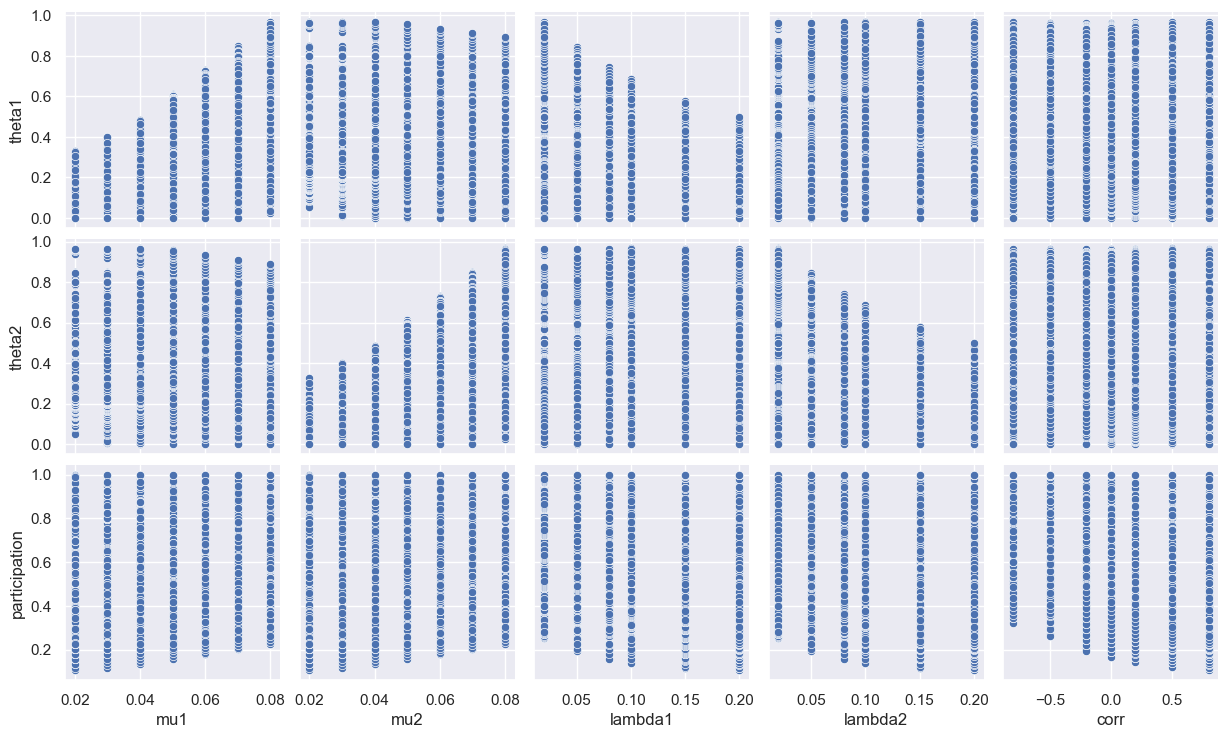

In [23]:
sns.pairplot(df,
             x_vars=['mu1', 'mu2', 'lambda1', 'lambda2', 'corr'],
             y_vars=['theta1', 'theta2', 'participation'])